In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('..')

# load daily close data for some ETFs
df = pd.read_csv('examples/ETF_prices.csv',index_col=0,parse_dates=True)
print('Loaded ', df.columns)

# resample to weekly frequency
weekly_prices = df.resample('W').ffill()

# compute compounded returns
weekly_returns = (weekly_prices).pct_change().dropna()

# compute the vol of SPY to create a risk driver series (toy example)
spy_vol = weekly_returns.SPY.ewm(span=52).std().ffill().fillna(0)

# store the returns shape
T, N = weekly_returns.shape

# inputs/parameters
ANNUALIZATION_FACTOR = 52
HALF_LIFE = ANNUALIZATION_FACTOR*10 # 10 years

Loaded  Index(['DBC', 'GLD', 'SPY', 'TLT'], dtype='object')


Effective number of scenarios of probabilities with uniform dist: 1006.0000000000003
Effective number of scenarios of probabilities via exp decay: 878.1857281784878
Effective number of scenarios of probabilities via gaussian kernel: 220.52113967772186


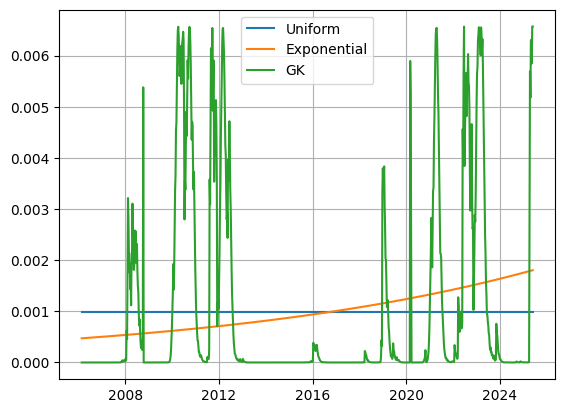

In [2]:
from pyvallocation import probabilities

# generate uniform probabilities
p_uniform = probabilities.generate_uniform_probabilities(T)
print('Effective number of scenarios of probabilities with uniform dist:', probabilities.compute_effective_number_scenarios(p_uniform))

# generate exponential decay probabilities
p_exp = probabilities.generate_exp_decay_probabilities(T,HALF_LIFE)
print('Effective number of scenarios of probabilities via exp decay:', probabilities.compute_effective_number_scenarios(p_exp))

# generate state conditioning probabilities via gaussian kernel
p_gk = probabilities.generate_gaussian_kernel_probabilities(spy_vol)
print('Effective number of scenarios of probabilities via gaussian kernel:', probabilities.compute_effective_number_scenarios(p_gk))

# visualize them
plt.plot(pd.Series(p_uniform,index=weekly_returns.index), label='Uniform')
plt.plot(pd.Series(p_exp,index=weekly_returns.index), label='Exponential')
plt.plot(pd.Series(p_gk,index=weekly_returns.index), label='GK')
plt.legend();plt.grid();plt.show()

In [3]:
from pyvallocation import moments

mu_uniform, cov_uniform = moments.estimate_sample_moments(weekly_returns,p_uniform)
mu_exp, cov_exp = moments.estimate_sample_moments(weekly_returns,p_exp)
mu_gk, cov_gk = moments.estimate_sample_moments(weekly_returns, p_gk)

mu_uniform_jorion = moments.shrink_mean_jorion(mu_uniform,cov_uniform,T)
print('Original mean from uniform prob:\n', mu_uniform*ANNUALIZATION_FACTOR)
print('Jorion-shirnked mean from uniform prob:\n', mu_uniform_jorion*ANNUALIZATION_FACTOR,'\n---')

print('Mean from exponential probabilities:\n',mu_exp*ANNUALIZATION_FACTOR)
print('Jorion-shirnked mean from exponential prob:\n', moments.shrink_mean_jorion(mu_exp,cov_exp,T)*ANNUALIZATION_FACTOR,'\n---')

print('Mean from state conditioning:\n',mu_gk*ANNUALIZATION_FACTOR)
print('Jorion-shirnked mean from state conditioning:\n', moments.shrink_mean_jorion(mu_gk,cov_gk,T)*ANNUALIZATION_FACTOR,'\n---')

cov_uniform_lw_cc = moments.shrink_covariance_ledoit_wolf(weekly_returns,cov_uniform,target='constant_correlation')
cov_uniform_lw_id = moments.shrink_covariance_ledoit_wolf(weekly_returns,cov_uniform,target='identity')

Original mean from uniform prob:
 DBC    0.024524
GLD    0.104242
SPY    0.113997
TLT    0.037689
Name: mu, dtype: float64
Jorion-shirnked mean from uniform prob:
 DBC    0.039253
GLD    0.086396
SPY    0.092165
TLT    0.047038
Name: mu, dtype: float64 
---
Mean from exponential probabilities:
 DBC    0.030864
GLD    0.109510
SPY    0.126099
TLT    0.017656
Name: mu, dtype: float64
Jorion-shirnked mean from exponential prob:
 DBC    0.039221
GLD    0.091669
SPY    0.102732
TLT    0.030414
Name: mu, dtype: float64 
---
Mean from state conditioning:
 DBC   -0.013594
GLD    0.109575
SPY    0.083216
TLT    0.054685
Name: mu, dtype: float64
Jorion-shirnked mean from state conditioning:
 DBC    0.013998
GLD    0.090472
SPY    0.074106
TLT    0.056392
Name: mu, dtype: float64 
---


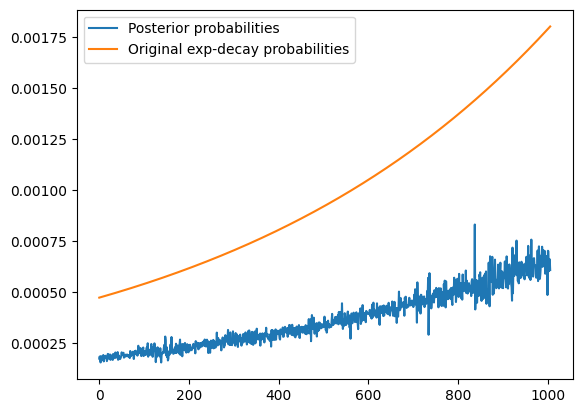

In [4]:
from pyvallocation.views import FlexibleViewsProcessor, BlackLittermanProcessor

mu_views = np.array([0.03,0.05,0.05,0.03])/52

fv = FlexibleViewsProcessor(weekly_returns,mean_views=mu_views,prior_probabilities=p_exp)
mu_fv, cov_fv = fv.get_posterior()
q_fv = fv.get_posterior_probabilities()

bl = BlackLittermanProcessor(prior_mean=mu_exp,prior_cov=cov_exp,absolute_views=mu_views)
mu_bl, cov_bl = bl.get_posterior()

plt.plot(q_fv, label='Posterior probabilities')
plt.plot(p_exp,label='Original exp-decay probabilities')
plt.legend();plt.show()

In [5]:
from pyvallocation.optimization import MeanCVaR, MeanVariance, build_G_h_A_b
G,h, A, b = build_G_h_A_b(N,total_weight=0,long_only=False,bounds=(-1.0,2.0))

# mean variance efficient frontier
MeanVariance(mu_uniform_jorion,cov_uniform_lw_cc.values,G,h,A,b).efficient_frontier()

# mean cvar efficient frontier
MeanCVaR(weekly_returns.values,G,h,A,b).efficient_frontier().round(2)

array([[ 0.  , -0.17, -0.34, -0.52, -0.69, -0.86, -1.  , -1.  , -1.  ],
       [ 0.  ,  0.16,  0.33,  0.49,  0.65,  0.82,  0.98,  1.2 ,  0.  ],
       [ 0.  ,  0.1 ,  0.2 ,  0.3 ,  0.4 ,  0.5 ,  0.6 ,  0.68,  2.  ],
       [ 0.  , -0.09, -0.18, -0.27, -0.36, -0.46, -0.58, -0.88, -1.  ]])

In [6]:
from pyvallocation.portfolioapi import AssetsDistribution, PortfolioWrapper

ad = AssetsDistribution(
    mu = mu_uniform, cov= cov_uniform,
    # scenarios=weekly_returns,probabilities=p_exp
    )

pw = PortfolioWrapper(ad,num_portfolios=25)
# pw.set_costraints()
pw.initialize_optimizer('CVaR')
pw.set_efficient_frontier()
pw.efficient_frontier.round(2)

No custom constraints specified, using default ones
Computing scenarios from mu and cov, using distribution: Normal


array([[0.15, 0.14, 0.12, 0.11, 0.09, 0.08, 0.06, 0.05, 0.03, 0.02, 0.01,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  ],
       [0.13, 0.14, 0.15, 0.17, 0.18, 0.19, 0.21, 0.22, 0.24, 0.25, 0.27,
        0.28, 0.3 , 0.32, 0.34, 0.35, 0.37, 0.4 , 0.42, 0.44, 0.46, 0.48,
        0.49, 0.51, 0.  ],
       [0.25, 0.26, 0.27, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.35,
        0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.41, 0.42, 0.43, 0.43, 0.44,
        0.45, 0.47, 1.  ],
       [0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.4 , 0.38, 0.37,
        0.35, 0.33, 0.3 , 0.27, 0.25, 0.22, 0.19, 0.16, 0.14, 0.11, 0.08,
        0.05, 0.03, 0.  ]])

In [7]:
pw.get_portfolios_return_constraint(np.array([0.02,0.05,0.07,0.1,0.15])/ANNUALIZATION_FACTOR)

[array([0.15074267, 0.12851318, 0.25253028, 0.46821387]),
 array([0.15074267, 0.12851318, 0.25253028, 0.46821387]),
 array([0.1057191 , 0.1665414 , 0.28560013, 0.44213937]),
 array([0.        , 0.43662121, 0.42750219, 0.1358766 ]),
 array([0., 0., 1., 0.])]

In [8]:
pw.get_portfolios_risk_constraint((np.array([0.0001,0.01,0.02,0.03,0.05,0.1,0.15])/(ANNUALIZATION_FACTOR**.5)))

[array([0.15074267, 0.12851318, 0.25253028, 0.46821387]),
 array([0.02115254, 0.24988719, 0.34579544, 0.38316483]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 0.])]

In [9]:
pw.get_portfolios_risk_constraint((np.array([0.01,0.02,0.03,0.05,0.1,0.15])/ANNUALIZATION_FACTOR)**.5)

[array([0., 0., 1., 0.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 0.])]

In [10]:
from scipy.stats import t

def t_distribution(mu, cov, n, df=5):
    d = len(mu)
    g = np.random.gamma(df / 2., 2. / df, n)
    z = np.random.multivariate_normal(np.zeros(d), cov, n)
    return mu + z / np.sqrt(g)[:, None]

pw = PortfolioWrapper(ad,dist=lambda mu, cov, n: t_distribution(mu, cov, n, df=5))
pw.initialize_optimizer('CVaR')
pw.set_efficient_frontier()
pw.efficient_frontier.round(2)

No custom constraints specified, using default ones
Computing scenarios from mu and cov, using distribution: <function <lambda> at 0x000001D74202BB00>


array([[ 0.17,  0.13,  0.07,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ],
       [ 0.06,  0.1 ,  0.15,  0.2 ,  0.23,  0.27,  0.31,  0.34,  0.23,
         0.  ],
       [ 0.25,  0.3 ,  0.34,  0.39,  0.44,  0.5 ,  0.56,  0.61,  0.77,
         1.  ],
       [ 0.51,  0.47,  0.44,  0.4 ,  0.32,  0.23,  0.13,  0.04, -0.  ,
         0.  ]])